## Analyze KNN Results

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.neighbors import KNeighborsClassifier
# from PIL import Image

In [56]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image, read_lists, prepare_device
from utils.analysis import knn, display_nearest_neighbors
import utils.visualizations as visualizations
import model.model as module_arch
from parse_config import ConfigParser



In [24]:
# Define visualization function

def show_results(results, class_list, idx, title):
    # pre_edit_resuilts = pre_edit_knn[data_type]
    # Keys: 'indices', 'distances', 'image_paths', 'labels'
    anchor_indices = results['indices'][idx]
    anchor_distances = results['distances'][idx]
    anchor_image_paths = results['image_paths'][idx]
    anchor_labels = results['labels'][idx]
    # anchor_labels = [class_list[label] for label in anchor1_labels]
    anchor_titles = []
    for label, distance in zip(anchor_labels, anchor_distances):
        anchor_titles.append("{} ({:.3f})".format(class_list[label], distance))

    display_nearest_neighbors(
        image_paths=anchor_image_paths,
        labels=anchor_titles,
        figure_title=title)

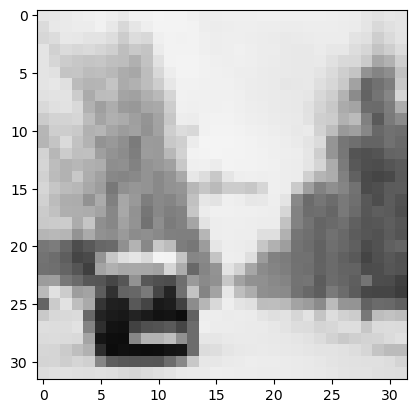

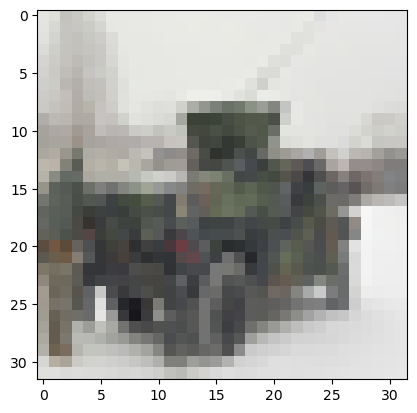

In [3]:
# Define constants, paths
key_image_path = 'data/editing/dummy/tank2.jpg'
value_image_path = 'data/editing/dummy/tank1.jpg'
pre_edit_knn_path = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1212_173631/models/pre_edit_knn.pth'
post_edit_knn_path = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1212_173631/models/post_edit_knn.pth'
edited_model_path = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1212_173631/models/edited_model.pth'

# Class list dictionary
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
IMAGE_SIZE = (32, 32)

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

key_image = load_image(key_image_path, resize=IMAGE_SIZE)
value_image = load_image(value_image_path, resize=IMAGE_SIZE)
visualizations.show_image(key_image)
visualizations.show_image(value_image)

### Load KNN Results Before and After Edit

In [4]:
pre_edit_knn = torch.load(pre_edit_knn_path)
post_edit_knn = torch.load(post_edit_knn_path)

### Features Visualizations

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


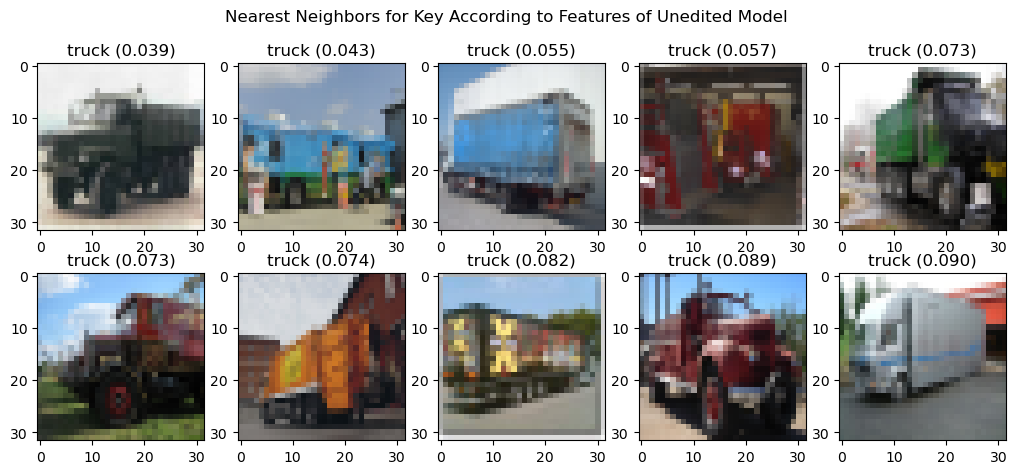

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


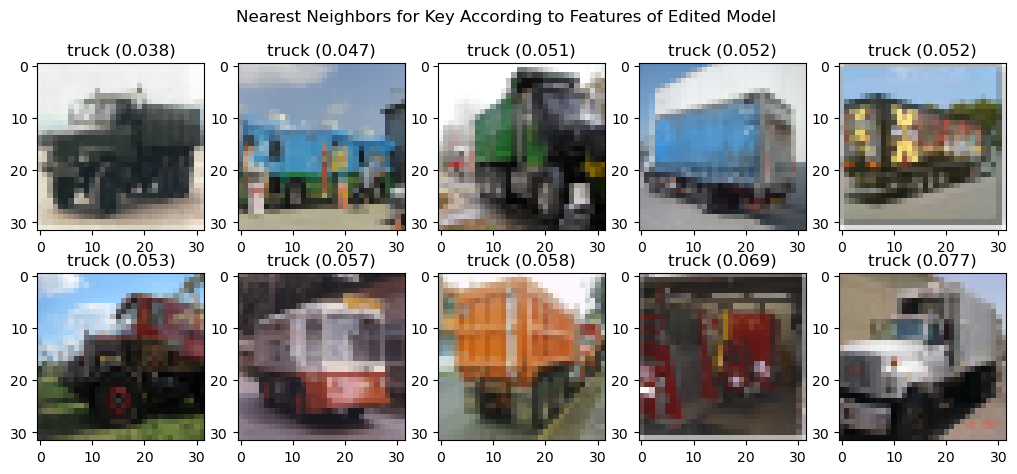

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


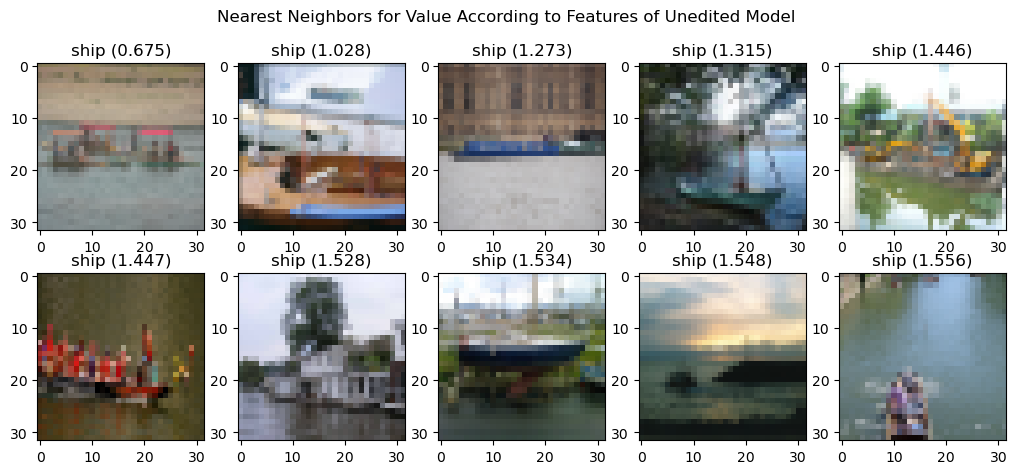

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


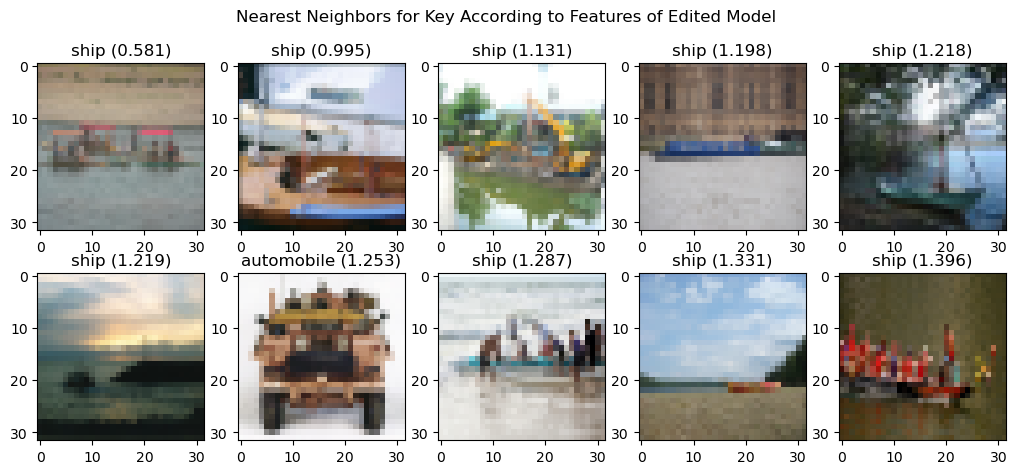

In [26]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
# data_type = 'features'
pre_edit_feature_knn = pre_edit_knn['features']
post_edit_feature_knn = post_edit_knn['features']

# Pre edit features for key (tank2)
show_results(
    results=pre_edit_feature_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Unedited Model')

# Post edit features for key (tank2)
show_results(
    results=post_edit_feature_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Edited Model')

# Features for value (tank1)
show_results(
    results=pre_edit_feature_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Unedited Model')

show_results(
    results=post_edit_feature_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Edited Model')


(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


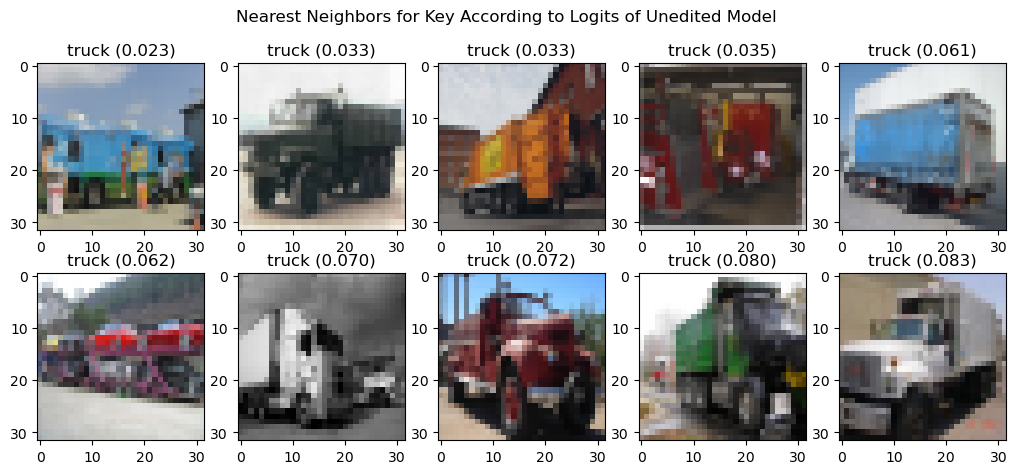

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


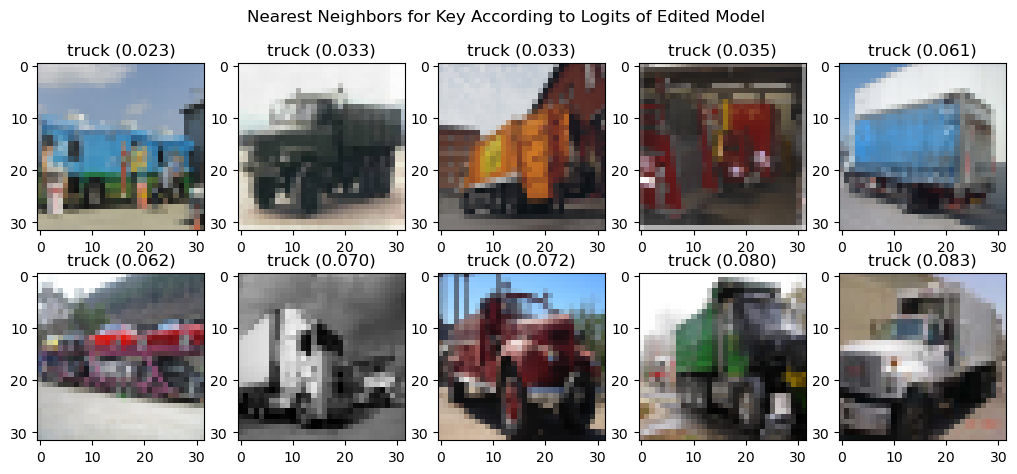

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


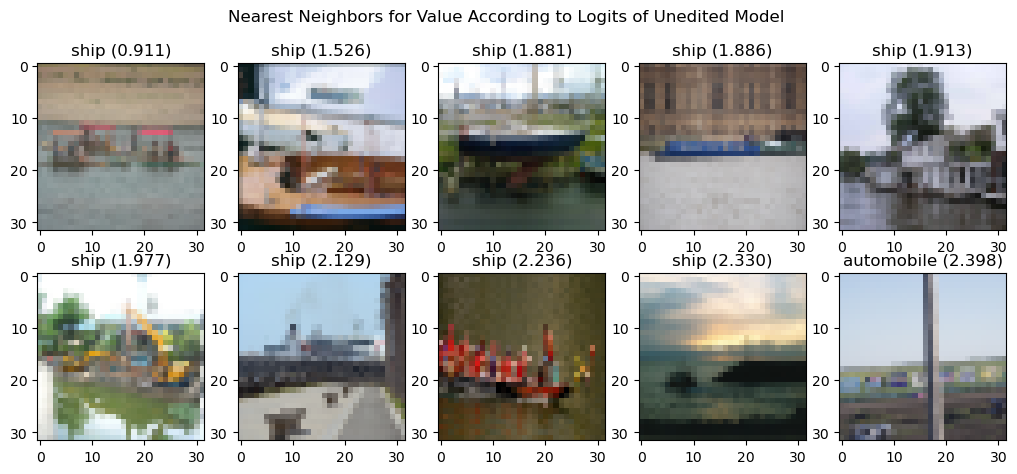

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


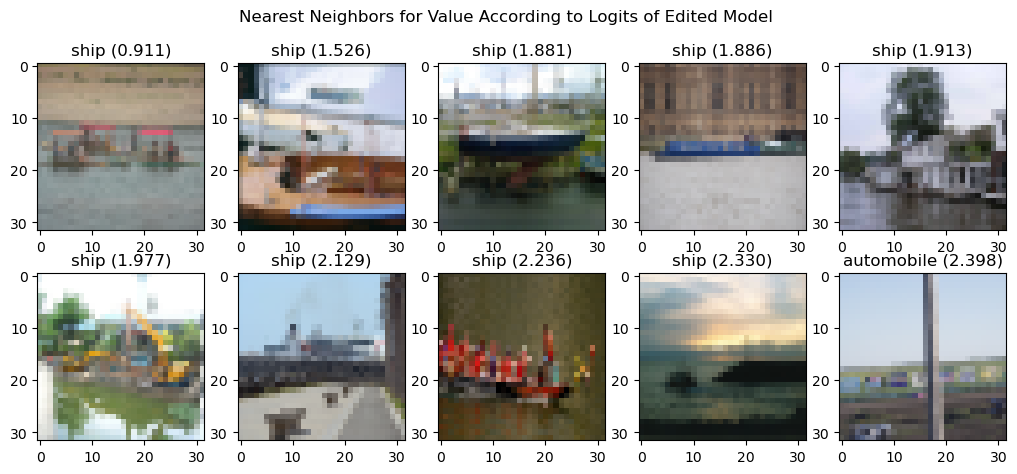

In [28]:
# LOGITS
pre_edit_logits_knn = pre_edit_knn['logits']
post_edit_logits_knn = pre_edit_knn['logits']

# Logits for key (tank2)
show_results(
    results=pre_edit_logits_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Unedited Model')
show_results(
    results=post_edit_logits_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Edited Model')

# Logits for value (tank1)
show_results(
    results=pre_edit_logits_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Unedited Model')
show_results(
    results=post_edit_logits_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Edited Model')

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


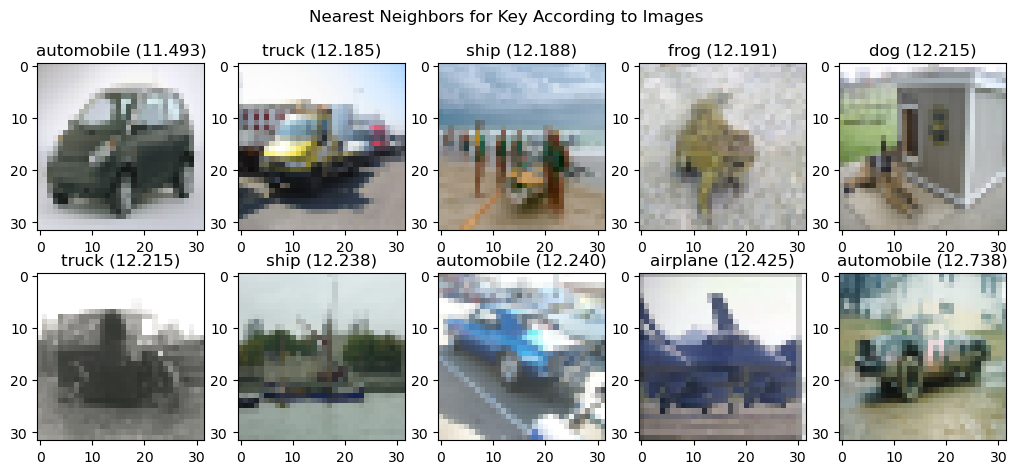

(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)
(3, 32, 32)
post transpose: (32, 32, 3)


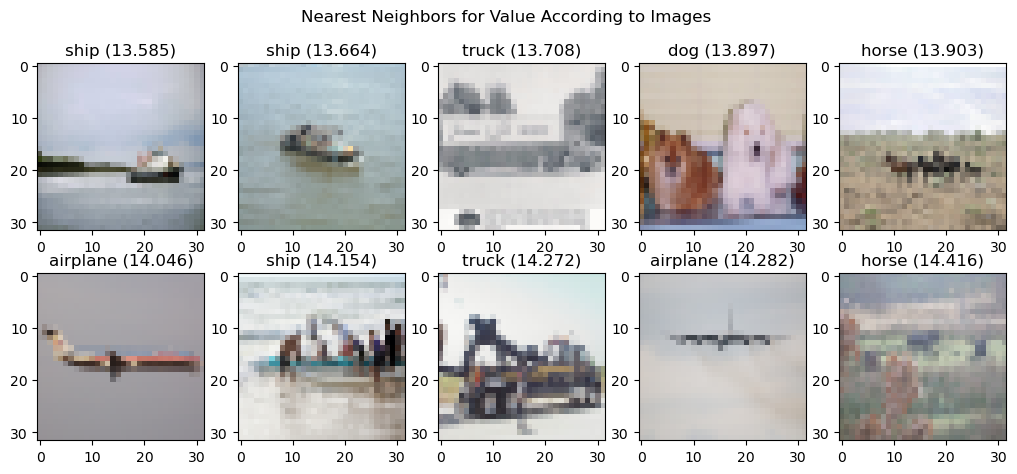

In [30]:
# IMAGES
pre_edit_images_knn = pre_edit_knn['images']
post_edit_images_knn = post_edit_knn['images']
# Features for key (tank2)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Images')
# show_results(
#     results=post_edit_images_knn, 
#     class_list=class_list, 
#     idx=0, 
#     title='Nearest Neighbors for Key According to Images of Edited Model')

# Features for value (tank1)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Images')
# show_results(
#     results=post_edit_images_knn, 
#     class_list=class_list, 
#     idx=1, 
#     title='Nearest Neighbors for Value According to Images of Edited Model')

### Given neighbors of the value image, find distances from key

In [48]:
from scipy.spatial import distance
def calculate_distance(u, v, metric='minkowski'):
    if metric == 'minkowski':
        return distance.minkowski(u, v)
    else:
        raise ValueError("Distance metric {} not supported.".format(metric))

In [49]:
def calculate_distances(
    vectors, 
    anchor, 
    metric='minkowski'):
    '''
    Given a list of vectors, calculate the distances from anchor using metric provided

    Arg(s):
        vectors : N x D np.array or list[np.array]
            N vectors of same shape of anchor
        anchor : D-dim np.vector
            Point to calculate distance from
        metric : str
            type of distance metric to use

    Returns:
        N-dim np.array : list of distances from anchor point
    '''
    distances = []
    for vector in vectors:
        distance = calculate_distance(vector, anchor, metric=metric)
        distances.append(distance)
    
    distances = np.stack(distances, axis=0)

    return distances

In [53]:
# Sanity check that A's neighbors get the correct distances in feature space

features_results = pre_edit_knn['images']
knn_distances = features_results['distances'][0]
knn_image_paths = features_results['image_paths'][0]
flattened_key_image = np.copy(key_image)
flattened_key_image = flattened_key_image.flatten()
print(flattened_key_image.shape)

images = []
for path in knn_image_paths:
    
    image = load_image(path, resize=IMAGE_SIZE)
    image = image.flatten()
    images.append(image)

distances = calculate_distances(
    vectors=images,
    anchor=flattened_key_image
)
for knn_dist, minkowski_dist in zip(knn_distances, distances):
    assert np.abs(knn_dist - minkowski_dist) < 1e-5

(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)
(3072,)


### Key Image Neighbor Analysis

Find the top neighbors of the key image before the edit
Calculate the distances in the feature and logit space to the value image before and after the edit and see how they differ.



In [84]:
# Load config file, models, and dataloader
config_path = "saved/edit/debug/CINIC10_ImageNet-VGG_16/1212_173631/models/config.json"
config_json = read_json(config_path)
config = ConfigParser(config_json)
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Load original and edited model
original_model_path = "external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt"
edited_model_path = "saved/edit/debug/CINIC10_ImageNet-VGG_16/1212_173631/models/edited_model.pth"

original_model = config.init_obj('arch', module_arch, layernum=layernum)
original_context_model = original_model.context_model
# original_model = original_model.restore_model(original_model_path)
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)
edited_context_model = edited_model.context_model

original_model.eval()
edited_model.eval()

# Get images that are neighbors of key (idx=0)
feature_neighbor_image_paths = pre_edit_knn['features']['image_paths'][0]
feature_neighbor_images = []
for path in feature_neighbor_image_paths:
    feature_neighbor_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))

feature_neighbor_images = torch.stack(feature_neighbor_images, dim=0)
print(feature_neighbor_images.shape)
# Feed through original and edited model to get features/logits
with torch.no_grad():
    feature_neighbor_images = feature_neighbor_images.to(device)
    original_logits = original_context_model(feature_neighbor_images)
    original_features = original_model.get_feature_values()['post']
    original_features = original_features.reshape([original_features.shape[0], -1])

    print(original_features.shape)

    edited_logits = edited_context_model(feature_neighbor_images)
    edited_features = edited_model.get_feature_values()['post']
    edited_features = edited_features.reshape([edited_features.shape[0], -1])

    # get features for value image
    val_image = torch.tensor(value_image).type(torch.float32).to(device)
    val_image = torch.unsqueeze(val_image, dim=0)
    original_val_logits = original_context_model(val_image)
    original_val_features = original_model.get_feature_values()['post']
    original_val_features = original_val_features.reshape([original_val_features.shape[0], -1])

    edited_val_logits = edited_context_model(val_image)
    edited_val_features = edited_model.get_feature_values()['post']
    edited_val_features = edited_val_features.reshape([edited_val_features.shape[0], -1])


# Convert all back to cpu and numpy
original_features = original_features.cpu().numpy()
original_logits = original_logits.cpu().numpy()
edited_features = edited_features.cpu().numpy()
edited_logits = edited_logits.cpu().numpy()

original_val_features = original_val_features.cpu().numpy()
original_val_logits = original_val_logits.cpu().numpy()
edited_val_features = edited_val_features.cpu().numpy()
edited_val_logits = edited_val_logits.cpu().numpy()

torch.Size([10, 3, 32, 32])
torch.Size([10, 512])


In [97]:
# compute distances from original and edited model for anchor in feature space
original_model_feature_distances = calculate_distances(
    vectors=original_features,
    anchor=original_val_features)

edited_model_feature_distances = calculate_distances(
    vectors=edited_features,
    anchor=edited_val_features)

print("For the neighbors of the key image, these are the distances in the feature space to the value image before the edit: {}"
      .format(original_model_feature_distances))
print("And distances to the value image representation after the edit: {}".format(edited_model_feature_distances))
change = (edited_model_feature_distances - original_model_feature_distances) / original_model_feature_distances
mean_change = np.mean(change)
print("And the percent change: {} {}".format(mean_change, change))
value_feature_change = np.nan_to_num((edited_val_features - original_val_features) / original_val_features)
mean_value_feature_change = np.mean(value_feature_change)
print("Perhaps there is some influence of change in the features of the value image though: {}"
     .format(mean_value_feature_change))

For the neighbors of the key image, these are the distances in the feature space to the value image before the edit: [4.98777342 4.98202658 4.96568489 4.98126268 5.03129435 5.03127241
 4.96449423 4.92072248 4.95410919 4.95096445]
And distances to the value image representation after the edit: [3.09433055 3.07897639 3.08899593 3.06814647 3.1026926  3.09973812
 3.0640769  3.07506919 3.07550979 3.09557581]
And the percent change: -0.3802653686953307 [-0.37961686 -0.38198315 -0.37793154 -0.3840625  -0.38332119 -0.38390573
 -0.3828018  -0.3750777  -0.37920024 -0.37475297]
Perhaps there is some influence of change in the features of the value image though: -0.20324479043483734


/tmp/ipykernel_3986895/711641493.py:16: RuntimeWarning: invalid value encountered in divide
  value_feature_change = np.nan_to_num((edited_val_features - original_val_features) / original_val_features)


In [98]:
# compute distances in logit space
original_model_logit_distances = calculate_distances(
    vectors=original_logits,
    anchor=original_val_logits)

edited_model_logit_distances = calculate_distances(
    vectors=edited_logits,
    anchor=edited_val_logits)

# print(original_logits)
print(original_val_logits)
# print(edited_logits)
print(edited_val_logits)
print("For the neighbors of the key image, these are the distances in the logit space to the value image before the edit: {}"
      .format(original_model_logit_distances))
print("And distances to the value image representation after the edit: {}".format(edited_model_logit_distances))
change = (original_model_logit_distances - edited_model_logit_distances) / edited_model_logit_distances
print("And the percent change: {}".format(change))

value_logit_change = np.nan_to_num((edited_val_logits - original_val_logits) / original_val_logits)
mean_value_logit_change = np.mean(value_logit_change)
print("Perhaps there is some influence of change in the features of the value image though: {}"
     .format(mean_value_logit_change))

[[ 1.1887832  -0.1847669  -0.98308927  0.17026277 -0.26924554 -1.0271344
  -1.3942275  -3.026613    4.1889033   1.3371737 ]]
[[ 1.2579614  -0.1650098  -0.51095563 -0.19014134  0.1705075  -0.47945145
  -1.4941994  -3.475605    4.6654644   0.22146893]]
For the neighbors of the key image, these are the distances in the logit space to the value image before the edit: [8.43611717 8.43434238 8.39973831 8.44197464 8.49973679 8.50845528
 8.41118717 8.33571434 8.39442062 8.37571049]
And distances to the value image representation after the edit: [4.38555717 4.37279129 4.40409756 4.32971239 4.42939091 4.43587399
 4.31340933 4.34699297 4.35385752 4.43135071]
And the percent change: [0.92361354 0.92882345 0.90725528 0.94977723 0.91894032 0.91810121
 0.95000904 0.91758174 0.92804211 0.89010328]
Perhaps there is some influence of change in the features of the value image though: -0.531279444694519
